In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.3, palette='Set2')
%matplotlib inline
from collections import defaultdict
from scipy.stats import entropy
import plotly.plotly as py
import plotly.graph_objs as go
import os
from pprint import pprint

In [2]:
out_path = './'

enrichment = pd.read_csv('./processed/enrichment.csv', index_col=0) # read in our data
enrichment.drop(['beads'],axis=1, inplace=True)
counts = pd.read_csv('./processed/aggregated_counts.csv', index_col=0)
metadata_cols = ['virus', 'start', 'end', 'sequence', 'strains'] # nonnumeric columns
sample_cols = [c for c in enrichment.columns.values if not any([c in metadata_cols, 'input' in c, 'beads' in c])] # data columns

In [3]:
def calc_percentiles(series):
    N = float(len(series))
    def calc_value_percentile(x):
        values_below = series < x
        N_values_below = float(values_below.sum())
        return N_values_below / N
    
    return series.map(calc_value_percentile)

enrichment_percentiles = enrichment[sample_cols].apply(calc_percentiles, axis=0)

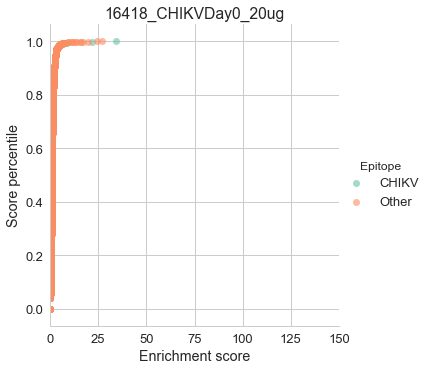

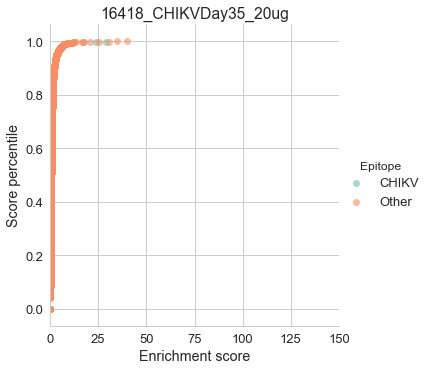

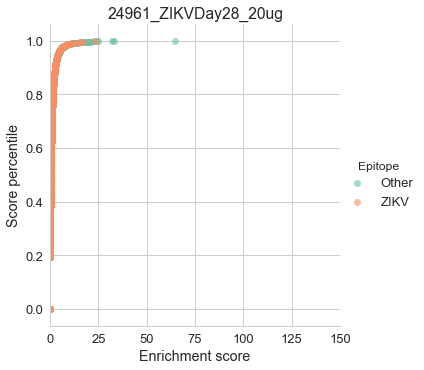

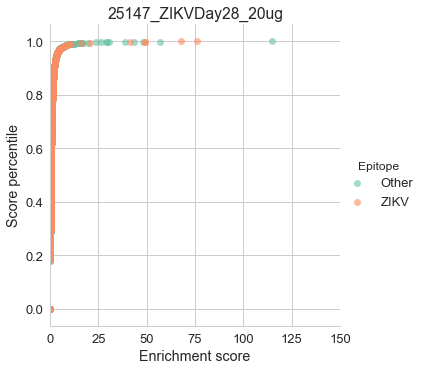

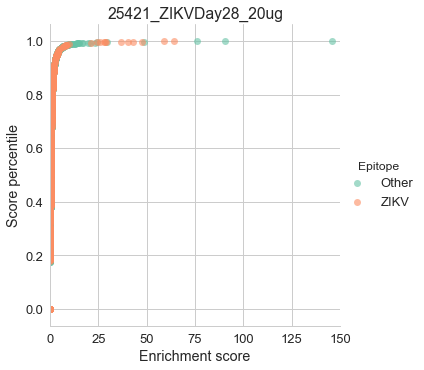

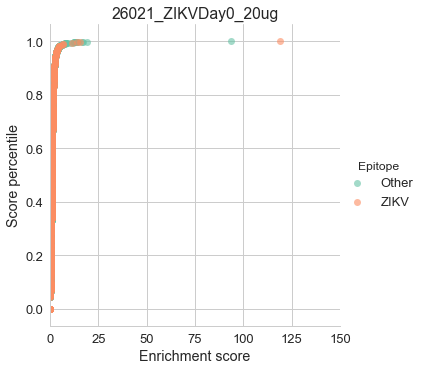

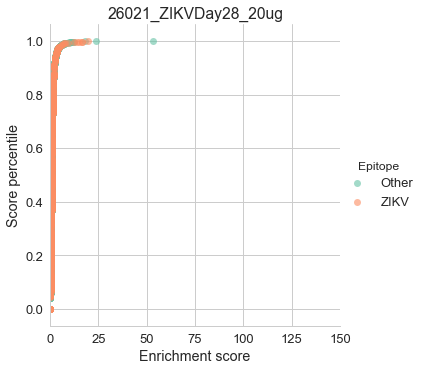

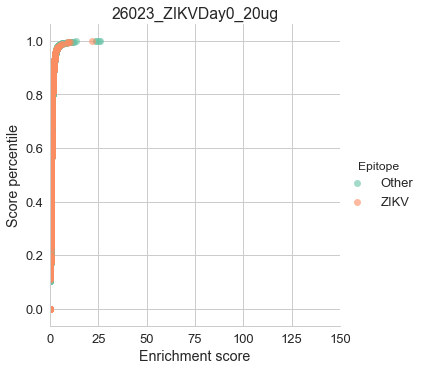

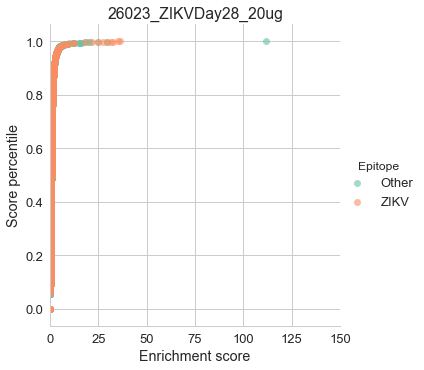

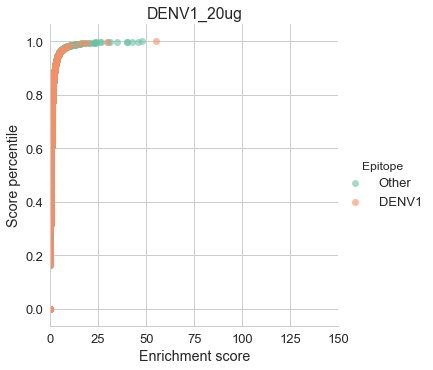

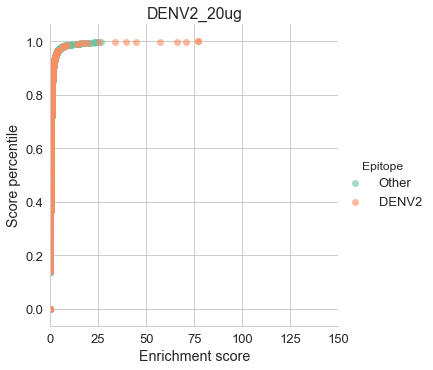

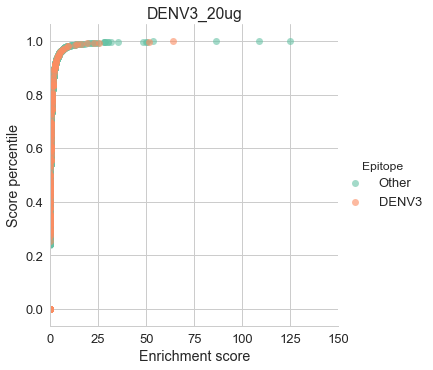

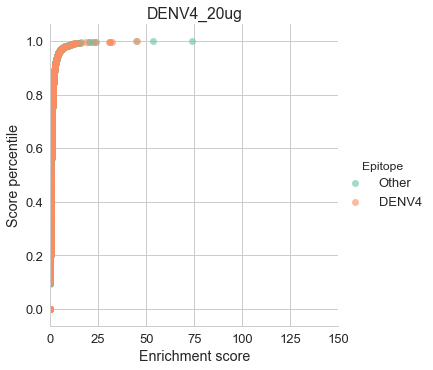

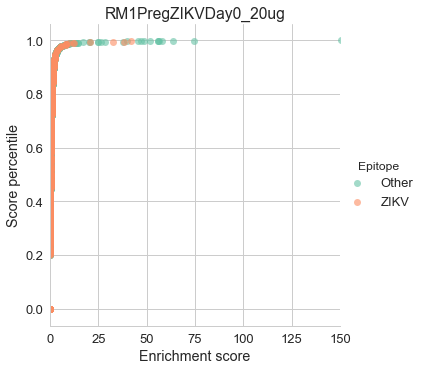

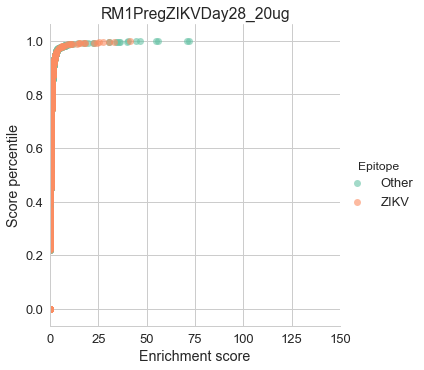

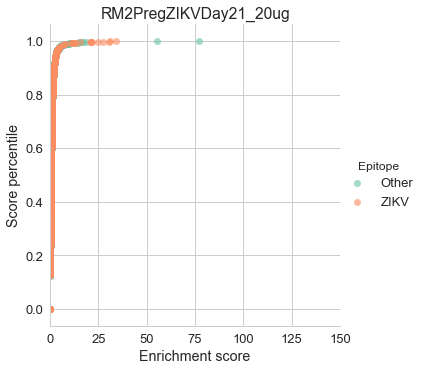

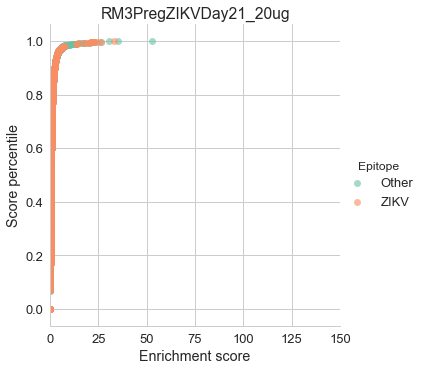

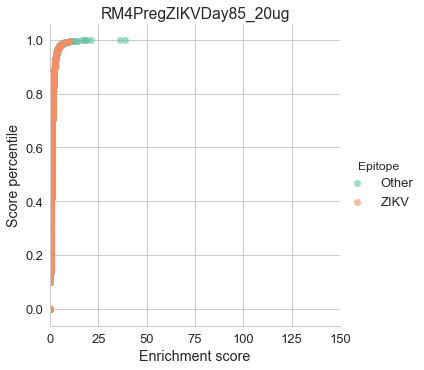

In [15]:
def plot_enrichment_percentiles(serum):
    
    autologous = []
    
    for virus in enrichment['virus']:
        if virus in serum: 
            autologous.append(virus)
        else:
            autologous.append('Other')
    
    values = {'x': enrichment[serum],
              'y': enrichment_percentiles[serum],
              'hue': autologous}
    
    values = pd.DataFrame(values)
    
    ax = sns.lmplot('x', 'y', values, hue='hue', fit_reg=False, scatter_kws={'alpha': 0.6})
    ax._legend.set_title('Epitope')

    plt.xlim((0,150))
    plt.ylabel('Score percentile')
    plt.xlabel('Enrichment score')
    plt.title(serum)
    plt.show()
    plt.close()
    
for serum in sample_cols:
    plot_enrichment_percentiles(serum)

# Each sera sample strongly binds only a small percentage of epitopes. These tend to be a mix of autologous and cross-reactive epitopes.

In [4]:
sera_bins = { 'preg': [ s for s in sample_cols if 'Preg' in s], 
              'ctrl': [s for s in sample_cols if 'Day0' in s],
              'flavi': [s for s in sample_cols if not any(['Day0' in s,
                                                          'Preg' in s,
                                                          'input' in s,
                                                          'bead' in s])]}

In [5]:
def bin_epitopes(serum, (start, end)):
    bins = defaultdict(list)
    
    for idx, row in enrichment.iterrows():
        exposed = row['start'] >= start and row['end'] <= end
        autologous = row['virus'] in serum
        
        if autologous:
            if exposed: 
                bins['exposed_autologous'].append(row[serum])
            else:
                bins['unexposed_autologous'].append(row[serum])
        else:
            bins['heterologous'].append(row[serum])
            
    return bins

exposed_regions = {'ZIKV': (474,2490), 
                  'DENV1': (437,2419),
                  'DENV2': (439,2421),
                  'DENV3': (437,2413),
                  'DENV4': (441,2423),
                  'CHIKV': (8557,11517)} 

def autologous_virus(serum):
    return [s for s in pd.unique(enrichment['virus']) if s in serum][0]

binned_epitopes = { s: bin_epitopes(s, exposed_regions[autologous_virus(s)]) 
                   for s in sera_bins['flavi']}    

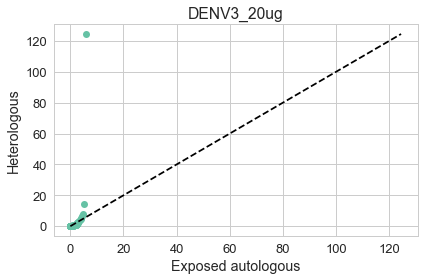

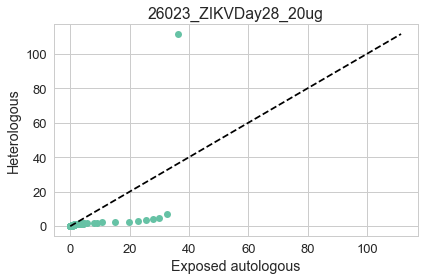

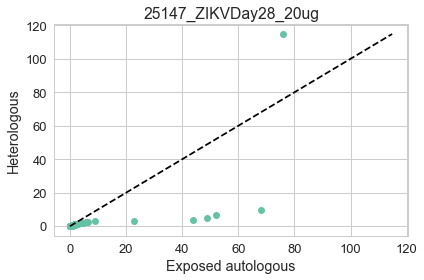

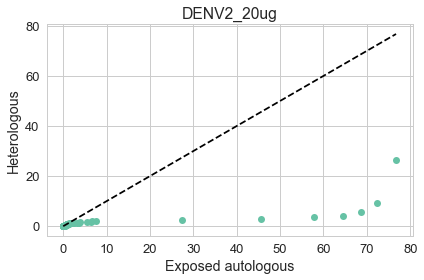

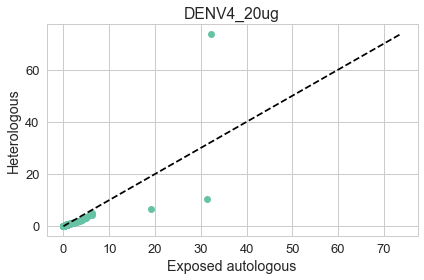

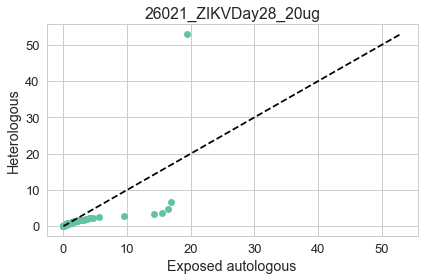

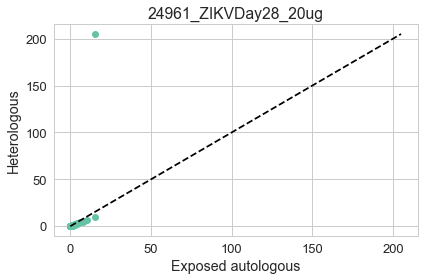

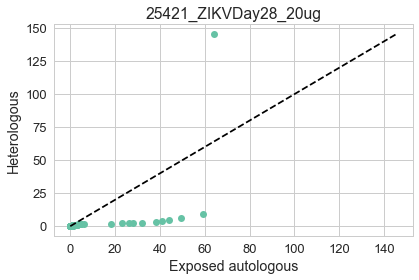

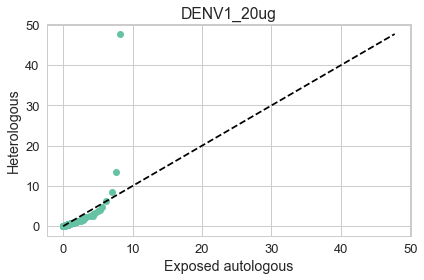

In [6]:
def plot_qq(series1, series2, title):
    percs = np.linspace(0,100,101)
    qn_1 = np.percentile(series1, percs)
    qn_2 = np.percentile(series2, percs)

    mask = (np.isfinite(qn_1)) & (np.isfinite(qn_2))
    

    x = np.linspace(np.min((qn_1.min(),qn_2.min())), np.max((qn_1.max(),qn_2.max())))
    fig, ax = plt.subplots(1,1)
    
    ax.plot(qn_1[mask],qn_2[mask], ls="", marker="o")
    ax.plot(x,x, color="k", ls="--")
    ax.set_title(title)
    return ax

for s, df in binned_epitopes.items():
    try:
        ax = plot_qq(df['exposed_autologous'], df['heterologous'], title=s)
        ax.set_xlabel('Exposed autologous')
        ax.set_ylabel('Heterologous')
        plt.tight_layout()
        plt.show()
    except:
        continue
# plot_qq(binned_epitopes['DENV3_20ug']['exposed_autologous'], binned_epitopes['DENV3_20ug']['heterologous'])

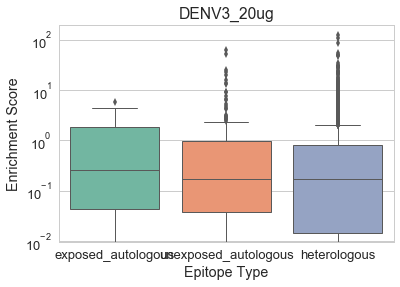

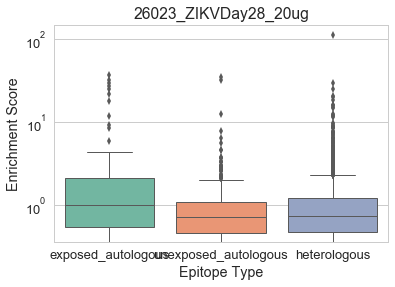

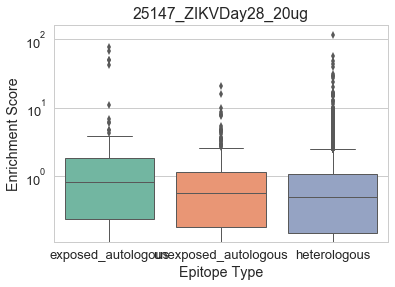

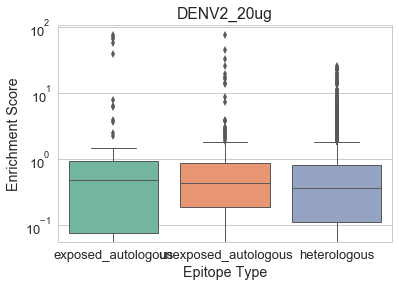

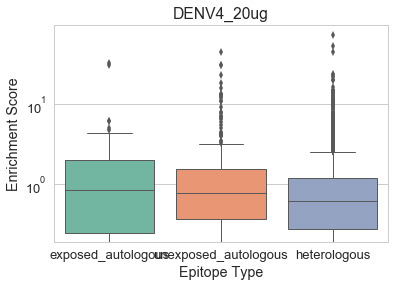

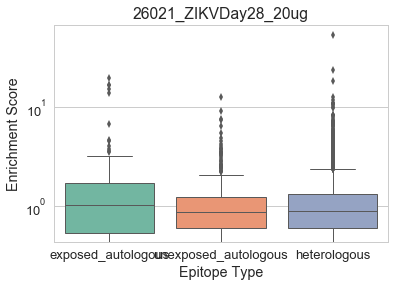

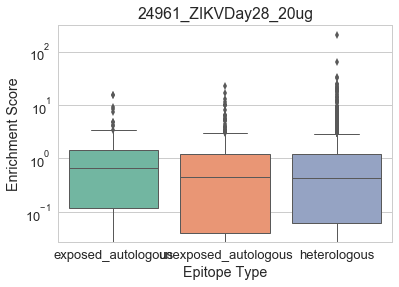

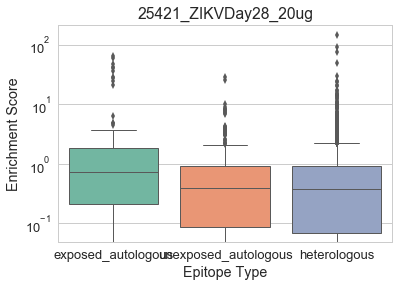

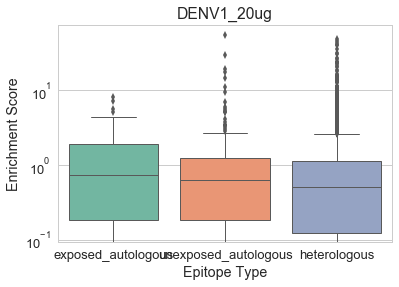

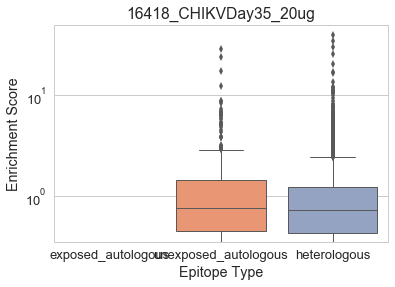

In [51]:
for sera, binned_eps in binned_epitopes.iteritems():
    tmp = binned_eps.melt(value_name='Enrichment Score', var_name='Epitope Type')
#     ax = sns.violinplot(x='Epitope Type', y='Enrichment Score', 
#                         order=['exposed_autologous', 'unexposed_autologous','heterologous'], 
#                         data=tmp, cut=0,inner='boxplot', scale='count', linewidth=1)

    plt.yscale('log')
    ax = sns.boxplot(x='Epitope Type', y='Enrichment Score', 
                        order=['exposed_autologous', 'unexposed_autologous','heterologous'], 
                        data=tmp, linewidth=1)
    ax.set_title(sera)
    plt.show()

# I don't see a clear pattern in the bound epitopes of surface vs. internal  vs. heterologous proteins. This is somewhat worrisome. 

In [62]:
epitopes_within_between = defaultdict(list)

for idx, row in enrichment.iterrows():
    
    autologous_sera_samples = [s for s in sera_bins['flavi'] if row['virus'] in s]
    heterologous_sera_samples = [s for s in sera_bins['flavi'] if row['virus'] in s]
    
    epitopes_within_between['%s_within'%row['virus']] += row[autologous_sera_samples].tolist()
    epitopes_within_between['%s_between'%row['virus']] += row[heterologous_sera_samples].tolist()
    
    
epitopes_within_between = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in epitopes_within_between.items() ]))
epitopes_within_between.dropna(axis=1, how='all', inplace=True)
epitopes_within_between = epitopes_within_between.melt(var_name='Epitope_Sera', value_name='Enrichment')

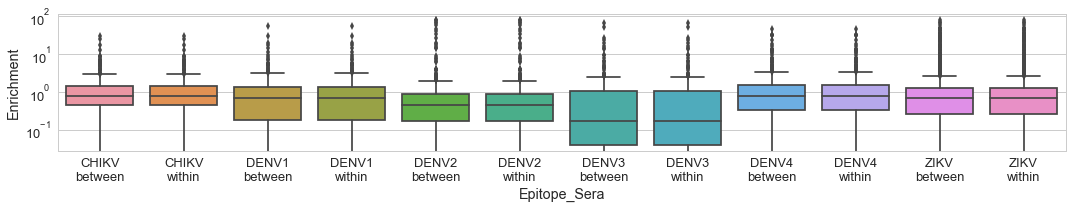

In [70]:
fig, ax = plt.subplots(figsize=(15,3))
plt.yscale('log')
sns.boxplot(x='Epitope_Sera', y='Enrichment', data=epitopes_within_between, ax = ax)
ax.set_xticklabels([ s.get_text().replace('_', '\n') for s in ax.get_xticklabels()])
plt.tight_layout()

# Overall, epitopes appear to be equally recognized by autologous vs. heterologous sera.

In [ ]:
# def calc_entropy(row):
#     total = row[sample_cols].sum()
# #     total = row.sum()
#     if total == 0:
#         return 0.
#     distrib = row[sample_cols].map(lambda x: float(x) / float(total))
# #     distrib = row.map(lambda x: float(x) / float(total))

#     return entropy(distrib.values)

# data['entropy'] = data.apply(calc_entropy, axis=1)
# data['max_enrichment'] = data[sample_cols].max(axis=1)